### Generate sample paths of a McKean-Vlasov SDE using PyTorch

Consider McKean-Vlasov SDE of the following form:

$$ 
\textrm{d}X_t = (\alpha \, X_t + \beta \, \mathbb{E}[X_t]) \textrm{d} t + \sigma \, \textrm{d} W_t, \quad X_0 = x_0.
$$

We approximate the solution $X_t, t \in [0,T]$ by using the following 

$$ 
\textrm{d}X_t = \bigl(\alpha \, X_t + \beta \, \sum^M_{i=1} \gamma_i \mathbf{1}_{[t_{i-1},t_i[}(t) \bigr) \textrm{d} t + \sigma \, \textrm{d} W_t, \quad X_0 = x_0,
$$

where we approximate $\mathbb{E}[X_t]$ for $t \in [t_{i-1},t_i[$ by a single constant $\gamma_i.$ Set $t_0 = 0$ and $t_M = T.$


In [88]:
import torch
import random
from torch import optim, nn
import math
import matplotlib.pyplot as plt
from torchviz import make_dot

import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [102]:
class MKVSDElinear_approx(torch.nn.Module):
    def __init__(self, gamma):
        super().__init__()
        # wrap gamma with nn.Parameter to compute gradients with respect to it using autograd
        self.gamma = nn.Parameter(gamma)
    def forward(self, x0, alpha, beta, sigma, M, dt, dW):
        X = x0 * torch.ones(M + 1)
        for i in range(1, M + 1):
            X[i] = X[i - 1] * (1 + alpha * dt) + beta * dt * self.gamma[i - 1] + sigma * dW[i - 1]
        return X
#     def getgradpath(self, x0, alpha, beta, sigma, M, dt):
#         xi = torch.zeros(M, M + 1) # N paths with M gradient values based on size of gamma, and M + 1 values
#         for j in range(M):
#             for i in range(1,M + 1):
#                 if (i == j):
#                     xi[j, i] = xi[j, i - 1] * (1 + alpha * dt) + beta * dt
#                 elif (i != j):
#                     xi[j, i] = xi[j, i - 1] * (1 + alpha * dt)
#         return xi

# seed initialise
torch.manual_seed(42)

# model parameters
M = 20  # number of discretisation steps

x0 = 1
sigma = 1
alpha = - 0.5
beta = 0.3
T = 0.2
dt = T / M

# simulate Brownian increments
dW = dt ** 0.5 * torch.randn(M)
# generate random values for gamma initialisation
gamma = torch.randn(M, requires_grad = True, dtype=torch.float, device=device)

MKVSDE_Xapprox = MKVSDElinear_approx(gamma).to(device)
MKVSDE_Xapproxpath = MKVSDE_Xapprox(x0, alpha, beta, sigma, M, dt, dW)
#MKVSDE_Xapprox_gradpath = MKVSDE_Xapprox.getgradpath(x0, alpha, beta, sigma, M, dt)

#print(MKVSDE_Xapproxpath.size())
#print(MKVSDE_Xapprox_gradpath)
# MKVSDE_Xapproxpath.backward(torch.ones_like(gamma))

In [122]:
torch.manual_seed(42)
callprice_true = torch.tensor(7.220219)
n_iteration = 50000
lr = 0.001

model = MKVSDElinear_approx(gamma)
#model = model.to(device)
#print(model.state_dict())

loss_fn = torch.nn.MSELoss(reduction = 'sum')
optimizer = torch.optim.SGD(model.parameters(),lr = lr, weight_decay = 0.0001)

i = 0
gamma_aver = 0

while i < n_iteration:
    
    model.train()
    dW = dt ** 0.5 * torch.randn(M)
    path_pred = model(x0, alpha, beta, sigma, M, dt, dW)
    price_loss = loss_fn(path_pred[1:], model.gamma)
    
    price_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    error = torch.abs(path_pred[1:] - model.gamma).detach().numpy()
    
    #print("No. of iteration: %i" % i)
    #print(f"Estimated path: {path_pred}")
    # print(f"Error in call price: {error}")
    gamma_iter = model.state_dict().get('gamma').numpy()
#     print(f'gamma iter is {gamma_iter}')
#     print(f'{model.state_dict()}')
    gamma_aver = gamma_aver * i / (i + 1) + gamma_iter * 1 / (i + 1)
    i += 1
    
print(model.state_dict())

print(gamma_aver)

OrderedDict([('gamma', tensor([0.9927, 0.9905, 0.9921, 0.9925, 0.9883, 0.9877, 0.9852, 0.9845, 0.9847,
        0.9805, 0.9808, 0.9774, 0.9765, 0.9804, 0.9744, 0.9740, 0.9720, 0.9732,
        0.9760, 0.9758]))])
[0.9986032  0.9963571  0.99383706 0.990962   0.9889424  0.9867697
 0.9854502  0.9842667  0.982621   0.98036766 0.9789616  0.97738403
 0.9757079  0.973786   0.9716248  0.97028506 0.9685063  0.96591216
 0.96402645 0.9621971 ]


Gamma with algorithm is 
[1.         0.99860322 0.99635708 0.99383706 0.99096203 0.98894238
 0.98676968 0.98545021 0.9842667  0.98262101 0.98036766 0.97896159
 0.97738403 0.97570789 0.973786   0.97162479 0.97028506 0.96850628
 0.96591216 0.96402645 0.96219712].

Gamma benchmark is 
[1.         0.998002   0.99600799 0.99401796 0.99203191 0.99004983
 0.98807171 0.98609754 0.98412732 0.98216103 0.98019867 0.97824024
 0.97628571 0.97433509 0.97238837 0.97044553 0.96850658 0.9665715
 0.96464029 0.96271294 0.96078944].



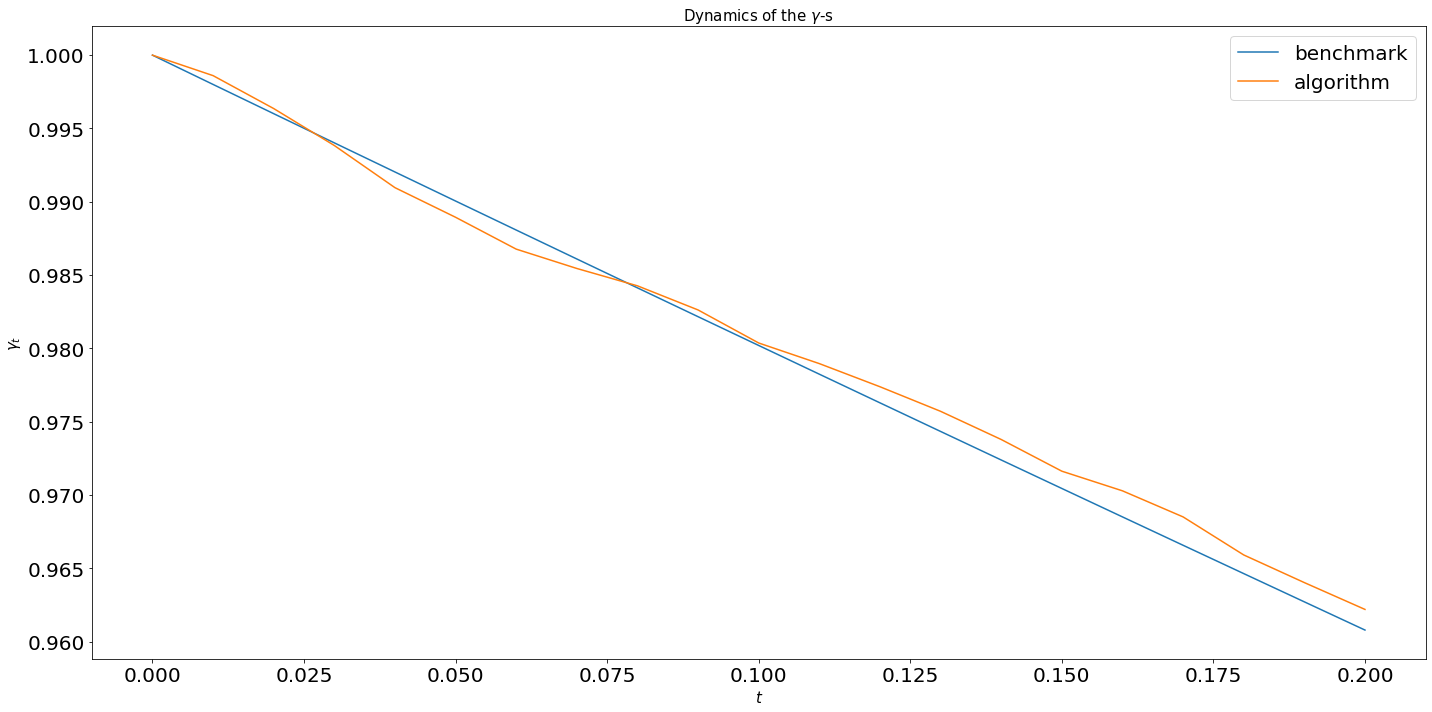

In [123]:
np.insert(gamma_aver, 0, x0)
gamma_aver_2 = np.zeros(M + 1)
gamma_aver_2[0] = x0
gamma_aver_2[1:] = gamma_aver 

#print(gamma_aver_2)

t_benchmark = np.linspace(0,T,M + 1)

t_sgd = np.linspace(0,T,M+1)

gamma_benchmark = np.exp((alpha + beta) * t_benchmark)

print(f'Gamma with algorithm is \n{gamma_aver_2}.\n')

print(f'Gamma benchmark is \n{gamma_benchmark}.\n')

fig, ax = plt.subplots(1, 1, figsize = (20, 10), tight_layout=True)

ax.set_title(r"Dynamics of the $\gamma$-s", fontsize = 15)
ax.set_xlabel(r'$t$',fontsize = 15)
ax.set_ylabel(r'$\gamma_t$',fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 20)
ax.tick_params(axis='both', which='minor', labelsize = 20)

ax.plot(t_benchmark, gamma_benchmark, label = 'benchmark')
ax.plot(t_sgd, gamma_aver_2, label = 'algorithm')

ax.legend(loc = 'best', fontsize = 20)